**Implementare model pentru setul de date MRNet**

Preprocesare imagini genunchi

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

from sklearn.metrics import roc_auc_score

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d cjinny/mrnet-v1 # https://www.kaggle.com/datasets/cjinny/mrnet-v1

Dataset URL: https://www.kaggle.com/datasets/cjinny/mrnet-v1
License(s): unknown
100% 5.67G/5.68G [01:10<00:00, 138MB/s]
100% 5.68G/5.68G [01:10<00:00, 86.2MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("mrnet-v1.zip", 'r') as zip_ref:
   zip_ref.extractall("knee_data")

In [ ]:
data_dir = "knee_data/MRNet-v1.0"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
print(train_dir)
print(val_dir)

knee_data/MRNet-v1.0/train
knee_data/MRNet-v1.0/valid


In [ ]:
def create_df(mode):
    sagittal = os.path.join(data_dir, f"{mode}/sagittal")
    axial = os.path.join(data_dir, f"{mode}/axial")
    coronal = os.path.join(data_dir, f"{mode}/coronal")
    axis = [sagittal, axial, coronal]
    labels = ['acl','meniscus','abnormal']
    paths = [os.path.join(data_dir, f"{mode}-{l}.csv") for l in labels]

    l1 = pd.read_csv(paths[0], header=None, names=['case', labels[0]], dtype={'case': str, labels[0]: np.int64})
    l2 = pd.read_csv(paths[1], header=None, names=['case', labels[1]], dtype={'case': str, labels[1]: np.int64})
    l3 = pd.read_csv( paths[2], header=None, names=['case', labels[2]], dtype={'case': str, labels[2]: np.int64})
    final_df = pd.DataFrame({'case': l1['case'], labels[0]: l1[labels[0]], labels[1]: l2[labels[1]], labels[2]: l3[labels[2]],})

    return final_df

In [ ]:
train_df = create_df('train')
val_df = create_df('valid')

In [ ]:
train_df.head()

,case,acl,meniscus,abnormal
0,0000,0,0,1
1,0001,1,1,1
2,0002,0,0,1
3,0003,0,1,1
4,0004,0,0,1


In [ ]:
train_df.tail()

,case,acl,meniscus,abnormal
1125,1125,0,1,1
1126,1126,0,1,1
1127,1127,0,0,0
1128,1128,0,0,1
1129,1129,1,0,1


Verificare valori lipsă în dataframe

In [ ]:
if train_df.isnull().values.any():
    print("Există valori lipsă în DataFrame-ul de antrenare!")
else:
    print("Nu există valori lipsă în DataFrame-ul de antrenare!")

Nu există valori lipsă în DataFrame-ul de antrenare!


In [ ]:
if val_df.isnull().values.any():
    print("Există valori lipsă în DataFrame-ul de validare!")
else:
    print("Nu există valori lipsă în DataFrame-ul de validare!")

Nu există valori lipsă în DataFrame-ul de validare!


Verificare distribuție clase

In [ ]:
for label in ['acl','meniscus','abnormal']:
    print(label)
    print('train',train_df[label].value_counts().to_dict())
    print('val',val_df[label].value_counts().to_dict())
    print('')

acl
train {0: 922, 1: 208}
val {0: 66, 1: 54}

meniscus
train {0: 733, 1: 397}
val {0: 68, 1: 52}

abnormal
train {1: 913, 0: 217}
val {1: 95, 0: 25}



Echlibrare distribuție clase

In [ ]:
from sklearn.utils import resample

train_abnormal_majority = train_df[train_df['abnormal'] == 1]
train_abnormal_minority = train_df[train_df['abnormal'] == 0]

train_abnormal_minority_oversampled = resample(
    train_abnormal_minority,
    replace=True,
    n_samples=len(train_abnormal_majority),
    random_state=42
)

train_df_abnormal_balanced = pd.concat([train_abnormal_majority, train_abnormal_minority_oversampled])

print(train_df_abnormal_balanced['abnormal'].value_counts())

abnormal
1    913
0    913
Name: count, dtype: int64


In [ ]:
for label in ['acl','meniscus','abnormal']:
    print(label)
    print('train', train_df_abnormal_balanced[label].value_counts().to_dict())
    print('')

acl
train {0: 1618, 1: 208}

meniscus
train {0: 1429, 1: 397}

abnormal
train {1: 913, 0: 913}



In [ ]:
# se observă că nu este posibilă o distribuție egală a claselor pentru toate cele 3 label-uri simultan (acl, meniscus, abnormal)

In [ ]:
no_pers1 = len(train_df[(train_df['meniscus'] == 0) & (train_df['acl'] == 0) & (train_df['abnormal'] == 0)])
no_pers2 = len(train_df[(train_df['meniscus'] == 0) & (train_df['acl'] == 0) & (train_df['abnormal'] == 1)])
no_pers3 = len(train_df[(train_df['meniscus'] == 0) & (train_df['acl'] == 1) & (train_df['abnormal'] == 0)])
no_pers4 = len(train_df[(train_df['meniscus'] == 0) & (train_df['acl'] == 1) & (train_df['abnormal'] == 1)])
no_pers5 = len(train_df[(train_df['meniscus'] == 1) & (train_df['acl'] == 0) & (train_df['abnormal'] == 0)])
no_pers6 = len(train_df[(train_df['meniscus'] == 1) & (train_df['acl'] == 0) & (train_df['abnormal'] == 1)])
no_pers7 = len(train_df[(train_df['meniscus'] == 1) & (train_df['acl'] == 1) & (train_df['abnormal'] == 0)])
no_pers8 = len(train_df[(train_df['meniscus'] == 1) & (train_df['acl'] == 1) & (train_df['abnormal'] == 1)])
print(no_pers1, no_pers2, no_pers3, no_pers4, no_pers5, no_pers6, no_pers7, no_pers8)

# se observă ca exista:
# 217 de persoane cu nicio problema
# nicio persoana care sa aiba probleme doar la acl
# nicio persoana care sa aiba probleme doar la menisc
# nicio persoana care sa aiba probleme doar la acl si menisc
# 125 de persoana care au probleme cu toate 3

217 433 0 83 0 272 0 125


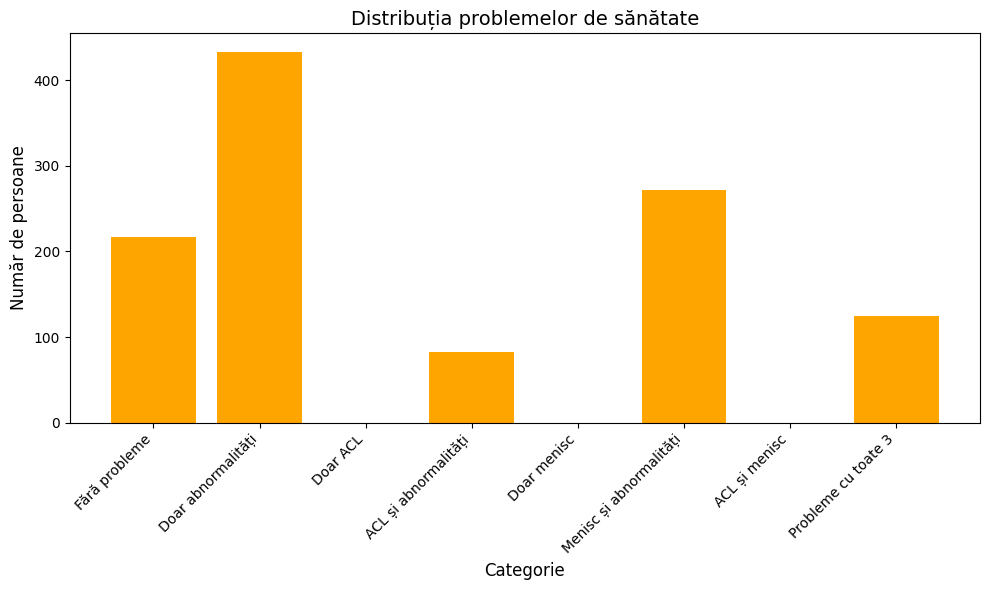

In [ ]:
categorii = [
    "Fără probleme",
    "Doar abnormalități",
    "Doar ACL",
    "ACL și abnormalități",
    "Doar menisc",
    "Menisc și abnormalități",
    "ACL și menisc",
    "Probleme cu toate 3",
]
valori = [no_pers1, no_pers2, no_pers3, no_pers4, no_pers5, no_pers6, no_pers7, no_pers8]

plt.figure(figsize=(10, 6))
plt.bar(categorii, valori, color='orange')
plt.title("Distribuția problemelor de sănătate", fontsize=14)
plt.xlabel("Categorie", fontsize=12)
plt.ylabel("Număr de persoane", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
train_df['axial'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'axial', f"{x}.npy"))
train_df['coronal'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'coronal', f"{x}.npy"))
train_df['sagittal'] = train_df['case'].apply(lambda x: os.path.join(train_dir, 'sagittal', f"{x}.npy"))

In [ ]:
train_df.head()

,case,acl,meniscus,abnormal,axial,coronal,sagittal
0,0000,0,0,1,knee_data/MRNet-v1.0/train/axial/0000.npy,knee_data/MRNet-v1.0/train/coronal/0000.npy,knee_data/MRNet-v1.0/train/sagittal/0000.npy
1,0001,1,1,1,knee_data/MRNet-v1.0/train/axial/0001.npy,knee_data/MRNet-v1.0/train/coronal/0001.npy,knee_data/MRNet-v1.0/train/sagittal/0001.npy
2,0002,0,0,1,knee_data/MRNet-v1.0/train/axial/0002.npy,knee_data/MRNet-v1.0/train/coronal/0002.npy,knee_data/MRNet-v1.0/train/sagittal/0002.npy
3,0003,0,1,1,knee_data/MRNet-v1.0/train/axial/0003.npy,knee_data/MRNet-v1.0/train/coronal/0003.npy,knee_data/MRNet-v1.0/train/sagittal/0003.npy
4,0004,0,0,1,knee_data/MRNet-v1.0/train/axial/0004.npy,knee_data/MRNet-v1.0/train/coronal/0004.npy,knee_data/MRNet-v1.0/train/sagittal/0004.npy


In [ ]:
val_df['axial'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'axial', f"{x}.npy"))
val_df['coronal'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'coronal', f"{x}.npy"))
val_df['sagittal'] = val_df['case'].apply(lambda x: os.path.join(val_dir, 'sagittal', f"{x}.npy"))

In [ ]:
val_df.head()

,case,acl,meniscus,abnormal,axial,coronal,sagittal
0,1130,0,0,0,knee_data/MRNet-v1.0/valid/axial/1130.npy,knee_data/MRNet-v1.0/valid/coronal/1130.npy,knee_data/MRNet-v1.0/valid/sagittal/1130.npy
1,1131,0,0,0,knee_data/MRNet-v1.0/valid/axial/1131.npy,knee_data/MRNet-v1.0/valid/coronal/1131.npy,knee_data/MRNet-v1.0/valid/sagittal/1131.npy
2,1132,0,0,0,knee_data/MRNet-v1.0/valid/axial/1132.npy,knee_data/MRNet-v1.0/valid/coronal/1132.npy,knee_data/MRNet-v1.0/valid/sagittal/1132.npy
3,1133,0,0,0,knee_data/MRNet-v1.0/valid/axial/1133.npy,knee_data/MRNet-v1.0/valid/coronal/1133.npy,knee_data/MRNet-v1.0/valid/sagittal/1133.npy
4,1134,0,0,0,knee_data/MRNet-v1.0/valid/axial/1134.npy,knee_data/MRNet-v1.0/valid/coronal/1134.npy,knee_data/MRNet-v1.0/valid/sagittal/1134.npy


In [ ]:
train_len = len(train_df)
val_len = len(val_df)
print(train_len, val_len)

1130 120


Creare set de date de testare din setul de date de antrenare original

In [ ]:
test_df = train_df.sample(n=130, random_state=42)
train_df = train_df.drop(test_df.index)

print(f"Dimensiune train_df: {len(train_df)}")
print(f"Dimensiune val_df: {len(val_df)}")
print(f"Dimensiune test_df: {len(test_df)}")

Dimensiune train_df: 1000
Dimensiune val_df: 120
Dimensiune test_df: 130


Verificarea dimensinilor fiecarei imagini si a scalei valorilor pixelilor

In [ ]:
def check_images(df, target_size=(256, 256)):
    dimensiuni_diferite = 0
    normalizare = 0

    for idx, row in df.iterrows():
        axial_path, coronal_path, sagittal_path = row["axial"], row["coronal"], row["sagittal"]

        axial = np.load(axial_path)
        coronal = np.load(coronal_path)
        sagittal = np.load(sagittal_path)

        for image in [axial, coronal, sagittal]:
            # verificare dimensiuni imagine
            if (image.shape[1], image.shape[2]) == target_size:
                dimensiuni_diferite += 1

            # verificare scala valorilor pixelilor
            pixel_values = np.array(image)
            if pixel_values.max() > 1.0 or pixel_values.min() < -1.0:
                normalizare += 1

    return dimensiuni_diferite, normalizare

In [ ]:
dimensiuni_diferite, normalizare = check_images(train_df)
print(f"Numărul de imagini din setul de date de antrenare: {len(train_df) * 3}")
print(f"Numărul de imagini cu dimensiuni egale cu (256, 256): {dimensiuni_diferite}")
print(f"Numărul de imagini care necesită normalizare: {normalizare}")

Numărul de imagini din setul de date de antrenare: 3000
Numărul de imagini cu dimensiuni egale cu (256, 256): 3000
Numărul de imagini care necesită normalizare: 3000


In [ ]:
dimensiuni_diferite, normalizare = check_images(val_df)
print(f"Numărul de imagini din setul de date de validare: {len(val_df) * 3}")
print(f"Numărul de imagini cu dimensiuni egale cu (256, 256): {dimensiuni_diferite}")
print(f"Numărul de imagini care necesită normalizare: {normalizare}")


Numărul de imagini din setul de date de validare: 360
Numărul de imagini cu dimensiuni egale cu (256, 256): 360
Numărul de imagini care necesită normalizare: 360


In [ ]:
dimensiuni_diferite, normalizare = check_images(test_df)
print(f"Numărul de imagini din setul de date de validare: {len(test_df) * 3}")
print(f"Numărul de imagini cu dimensiuni egale cu (256, 256): {dimensiuni_diferite}")
print(f"Numărul de imagini care necesită normalizare: {normalizare}")

Numărul de imagini din setul de date de validare: 390
Numărul de imagini cu dimensiuni egale cu (256, 256): 390
Numărul de imagini care necesită normalizare: 390


Creare tranformări pentru a augmenta setul de date de antrenare și setul de date de validare

In [ ]:
# se definesc transformarile
train_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Creare clasă care permite utlizarea setului de date împreună cu DataLoader

In [ ]:
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.axis = ["axial", "coronal", "sagittal"]
        self.labels = ["acl", "meniscus", "abnormal"]

    def __len__(self):
        # The total number of samples is the number of scans * number of planes (3: axial, coronal, sagittal)
        return len(self.df) * len(self.axis)

    def __getitem__(self, idx):
        # Determine which scan and plane corresponds to this index
        scan_idx = idx // len(self.axis)  # Index of scan in the dataframe
        axis_idx = idx % len(self.axis)   # Which plane (axial, coronal, sagittal)

        # Get the file paths for the planes of the current scan
        row = self.df.iloc[scan_idx]
        axial_path, coronal_path, sagittal_path = row[self.axis].tolist()

        # Load the volume for the respective plane
        axial = np.load(axial_path)
        coronal = np.load(coronal_path)
        sagittal = np.load(sagittal_path)

        # Select the middle slice from each plane
        axial_slice = axial[len(axial) // 2]
        coronal_slice = coronal[len(coronal) // 2]
        sagittal_slice = sagittal[len(sagittal) // 2]

        # Choose the slice from the correct plane (axial, coronal, or sagittal)
        if axis_idx == 0:
            slice_image = axial_slice
        elif axis_idx == 1:
            slice_image = coronal_slice
        else:
            slice_image = sagittal_slice

        # Apply transformations to the slice (if applicable)
        if self.transform:
            slice_image = self.transform(Image.fromarray(slice_image))

        # Assign the label for this scan (same for all slices of a scan)
        label = torch.tensor(row[self.labels].tolist()).float()

        return {"image": slice_image, "label": label}



train_dataset = KneeDataset(train_df, transform=train_transforms)
val_dataset = KneeDataset(val_df, transform=val_transforms)
test_dataset = KneeDataset(test_df, transform=test_transforms)

print(f"Dimensiune set de date de antrenare: {len(train_dataset)}")
print(f"Dimensiune set de date de validare: {len(val_dataset)}")
print(f"Dimensiune set de date de testare: {len(test_dataset)}")

Dimensiune set de date de antrenare: 3000
Dimensiune set de date de validare: 360
Dimensiune set de date de testare: 390


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        # Convolutional layers (change input channels to 1 for grayscale images)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # 128x128x1 -> 128x128x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 128x128x32 -> 128x128x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # 128x128x64 -> 128x128x128

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Reduces size by a factor of 2

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Flattened size after pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)  # 3 classes: "acl", "meniscus", "abnormal"

    def forward(self, x):
        # Apply convolutional layers with ReLU activation
        x = self.pool(torch.relu(self.conv1(x)))  # -> [batch_size, 32, 64, 64]
        x = self.pool(torch.relu(self.conv2(x)))  # -> [batch_size, 64, 32, 32]
        x = self.pool(torch.relu(self.conv3(x)))  # -> [batch_size, 128, 16, 16]

        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 16 * 16)  # Flatten to a vector for the fully connected layers

        # Apply fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Output layer (no activation function here as we use CrossEntropyLoss)
        x = self.fc3(x)

        return x

In [ ]:
# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = BaselineCNN()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training loop with ROC AUC
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_rocs, val_rocs = [], []  # Store ROC AUC scores

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        all_labels = []
        all_outputs = []

        # Training phase
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(images)

            # Collect outputs and labels for ROC AUC
            all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Calculate loss and backpropagate
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy (assuming the labels are multi-label)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.numel()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions

        # Compute ROC AUC for the epoch
        all_labels = np.vstack(all_labels)
        all_outputs = np.vstack(all_outputs)
        epoch_roc = roc_auc_score(all_labels, all_outputs, average="weighted")

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_rocs.append(epoch_roc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, ROC AUC: {epoch_roc:.4f}")

        # Validation phase
        val_loss, val_accuracy, val_roc = evaluate_model_with_loss_and_roc(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_rocs.append(val_roc)

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, ROC AUC: {val_roc:.4f}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')  # Save the model with the best accuracy

    return train_losses, train_accuracies, train_rocs, val_losses, val_accuracies, val_rocs


def evaluate_model_with_loss_and_roc(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(images)

            # Collect outputs and labels for ROC AUC
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy (multi-label classification)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.numel()

    val_loss = running_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions

    # Compute ROC AUC
    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)
    roc_auc = roc_auc_score(all_labels, all_outputs, average="weighted")

    return val_loss, accuracy, roc_auc


train_losses, train_accuracies, train_rocs, val_losses, val_accuracies, val_rocs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

Epoch 1/10: 100%|██████████| 94/94 [00:45<00:00,  2.05it/s]


Epoch [1/10], Loss: 0.5380, Accuracy: 0.7559, ROC AUC: 0.5346
Validation Loss: 0.7782, Accuracy: 0.6361, ROC AUC: 0.5681


Epoch 2/10: 100%|██████████| 94/94 [00:14<00:00,  6.42it/s]


Epoch [2/10], Loss: 0.5201, Accuracy: 0.7612, ROC AUC: 0.6240
Validation Loss: 0.6747, Accuracy: 0.6472, ROC AUC: 0.6017


Epoch 3/10: 100%|██████████| 94/94 [00:15<00:00,  6.17it/s]


Epoch [3/10], Loss: 0.4990, Accuracy: 0.7644, ROC AUC: 0.6883
Validation Loss: 0.6549, Accuracy: 0.6602, ROC AUC: 0.6521


Epoch 4/10: 100%|██████████| 94/94 [00:14<00:00,  6.33it/s]


Epoch [4/10], Loss: 0.4810, Accuracy: 0.7726, ROC AUC: 0.7306
Validation Loss: 0.6789, Accuracy: 0.6574, ROC AUC: 0.7006


Epoch 5/10: 100%|██████████| 94/94 [00:15<00:00,  6.13it/s]


Epoch [5/10], Loss: 0.4728, Accuracy: 0.7759, ROC AUC: 0.7489
Validation Loss: 0.6169, Accuracy: 0.6667, ROC AUC: 0.7200


Epoch 6/10: 100%|██████████| 94/94 [00:14<00:00,  6.29it/s]


Epoch [6/10], Loss: 0.4684, Accuracy: 0.7764, ROC AUC: 0.7558
Validation Loss: 0.6925, Accuracy: 0.6639, ROC AUC: 0.7099


Epoch 7/10: 100%|██████████| 94/94 [00:14<00:00,  6.37it/s]


Epoch [7/10], Loss: 0.4550, Accuracy: 0.7849, ROC AUC: 0.7737
Validation Loss: 0.6099, Accuracy: 0.6778, ROC AUC: 0.7330


Epoch 8/10: 100%|██████████| 94/94 [00:15<00:00,  6.25it/s]


Epoch [8/10], Loss: 0.4464, Accuracy: 0.7857, ROC AUC: 0.7908
Validation Loss: 0.6488, Accuracy: 0.6574, ROC AUC: 0.7506


Epoch 9/10: 100%|██████████| 94/94 [00:15<00:00,  6.13it/s]


Epoch [9/10], Loss: 0.4361, Accuracy: 0.7887, ROC AUC: 0.8047
Validation Loss: 0.6415, Accuracy: 0.6778, ROC AUC: 0.7741


Epoch 10/10: 100%|██████████| 94/94 [00:14<00:00,  6.34it/s]


Epoch [10/10], Loss: 0.4279, Accuracy: 0.7957, ROC AUC: 0.8107
Validation Loss: 0.5908, Accuracy: 0.7009, ROC AUC: 0.7832


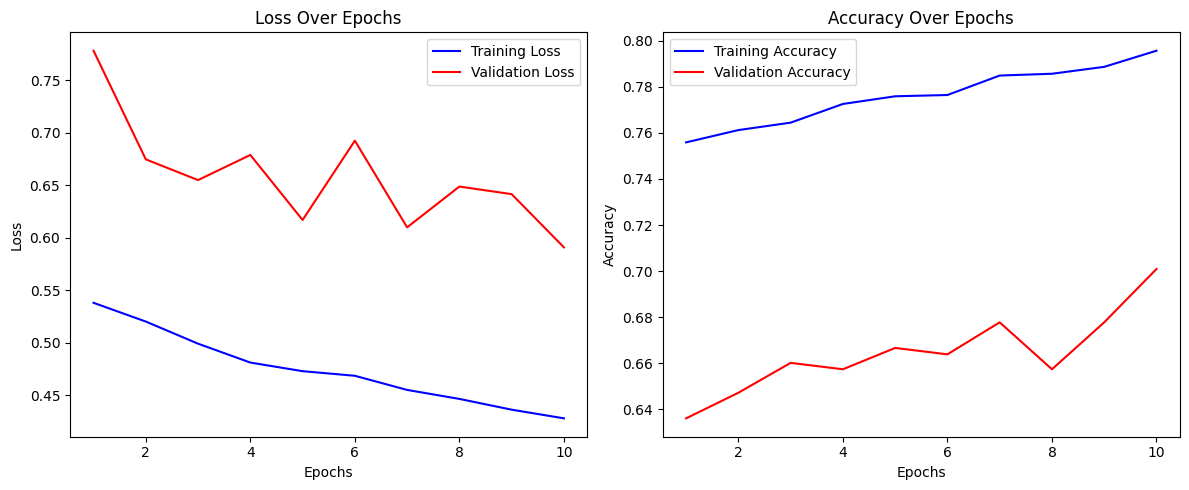

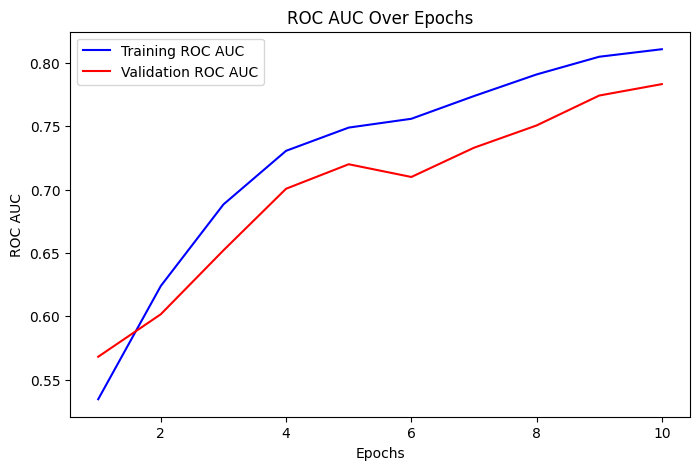

In [ ]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label="Training Loss")
    plt.plot(epochs, val_losses, 'r-', label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label="Training Accuracy")
    plt.plot(epochs, val_accuracies, 'r-', label="Validation Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_roc_auc(train_rocs, val_rocs):
    plt.figure(figsize=(8, 5))
    epochs = range(1, len(train_rocs) + 1)
    plt.plot(epochs, train_rocs, 'b-', label="Training ROC AUC")
    plt.plot(epochs, val_rocs, 'r-', label="Validation ROC AUC")
    plt.title("ROC AUC Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("ROC AUC")
    plt.legend()
    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
plot_roc_auc(train_rocs, val_rocs)

In [ ]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
test_loss, test_accuracy, roc_auc = evaluate_model_with_loss_and_roc(model, test_loader, criterion)

print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.7436, Test Loss: 0.5125, Test ROC AUC: 0.7825


In [ ]:
# Classification report
def get_predictions(model, data_loader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(images)

            # Collect outputs and labels for ROC AUC
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

            # Calculate accuracy (multi-label classification)
            predicted = torch.sigmoid(outputs) > 0.5
            all_labels.append(labels.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)

    return all_labels, all_outputs

def encode_combinations(labels):
    labels = labels.astype(int)  # Ensure integer format
    return ["".join(map(str, label)) for label in labels]



def get_classification_report(all_labels, all_outputs):
    all_outputs = (all_outputs > 0.5).astype(int)
    classification_report_str = classification_report(all_labels, all_outputs, target_names=["acl", "meniscus", "abnormal"], zero_division=0)
    print(classification_report_str)


def map_combinations_to_names(combinations):
    mapping = {
        "000": "no issues",
        "100": "meniscus",
        "010": "acl",
        "001": "abnormalities",
        "110": "meniscus, acl",
        "101": "meniscus, abnormalities",
        "011": "acl, abnormalities",
        "111": "meniscus, acl, abnormalities",
    }
    return [mapping.get(combo, "unknown") for combo in combinations]


def get_combination_classification_report_with_names(all_labels, all_outputs):
    # Encode ground truth and predictions as single labels
    true_combinations = encode_combinations(all_labels)
    pred_combinations = encode_combinations((all_outputs > 0.5).astype(int))

    # Map combinations to descriptive names
    true_combination_names = map_combinations_to_names(true_combinations)
    pred_combination_names = map_combinations_to_names(pred_combinations)

    # Generate the classification report with descriptive names
    combination_report = classification_report(
        true_combination_names,
        pred_combination_names,
        zero_division=0  # Avoid division errors for classes with no predictions
    )
    print("Classification Report (Label Combinations):")
    print(combination_report)

# Predictions and labels
all_labels, all_outputs = get_predictions(model, test_loader)

# Standard classification report for individual labels
get_classification_report(all_labels, all_outputs)

# Classification report for label combinations with descriptive names
get_combination_classification_report_with_names(all_labels, all_outputs)


              precision    recall  f1-score   support

         acl       0.68      0.23      0.34       114
    meniscus       0.61      0.47      0.53       129
    abnormal       0.78      0.96      0.86       294

   micro avg       0.74      0.69      0.71       537
   macro avg       0.69      0.55      0.58       537
weighted avg       0.72      0.69      0.67       537
 samples avg       0.68      0.57      0.59       537

Classification Report (Label Combinations):
                              precision    recall  f1-score   support

               abnormalities       0.37      0.82      0.51       117
          acl, abnormalities       0.30      0.33      0.32        63
     meniscus, abnormalities       0.44      0.08      0.14        48
meniscus, acl, abnormalities       0.41      0.18      0.25        66
                   no issues       0.56      0.15      0.23        96

                    accuracy                           0.38       390
                   macro avg 